<a href="https://colab.research.google.com/github/NickKornienko/Language-Identification-model/blob/main/LanguageUnderstanding_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/all_meta_data.csv')

In [ ]:
df.shape

(155712, 4)

In total we have have 155712 different files

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155712 entries, 0 to 155711
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   audio        155712 non-null  object 
 1   sample_rate  155712 non-null  int64  
 2   file_length  155712 non-null  float64
 3   label        155712 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 4.8+ MB


In [ ]:
df.head()

,audio,sample_rate,file_length,label
0,[ 0.0000000e+00 0.0000000e+00 0.0000000e+00 ...,22050,7.056009,english
1,[ 1.2191280e-12 -1.7915870e-12 5.2335475e-12 ...,22050,5.328027,english
2,[0. 0. 0. ... 0. 0. 0.],22050,5.976009,english
3,[0. 0. 0. ... 0. 0. 0.],22050,5.328027,english
4,[0. 0. 0. ... 0. 0. 0.],22050,5.400000,english


In [ ]:
#checining for missing data
df.isnull().sum().sum()

0

As we have sources our data from a third party which maintains and validates the data for use, we donot have any missing data. (Or corrupted files in our case)

Checking if all the audio files have the same sampling rate

In [ ]:
df['sample_rate'].unique()

array([22050])

Only one unique value exists its safe to that all audio has been recorded at same sampling rate.

Checking the average audio length for each language

In [ ]:
df.groupby('label')['file_length'].mean()

label
english    5.734928
french     3.792457
spanish    5.040139
Name: file_length, dtype: float64

Text(0, 0.5, 'Average audio length')

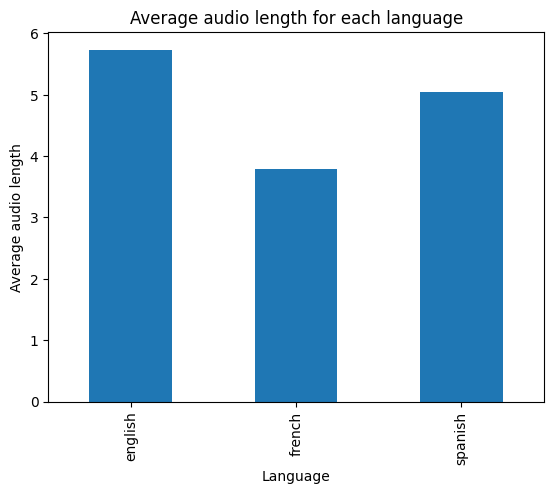

In [ ]:
df_group = df.groupby('label')['file_length'].mean()
df_group.plot(kind='bar')
plt.title('Average audio length for each language')
plt.xlabel('Language')
plt.ylabel('Average audio length')

In [ ]:
df_en=df.where(df['label']=='english')
df_fr = df.where(df['label']=='french')
df_sp = df.where(df['label']=='spanish')

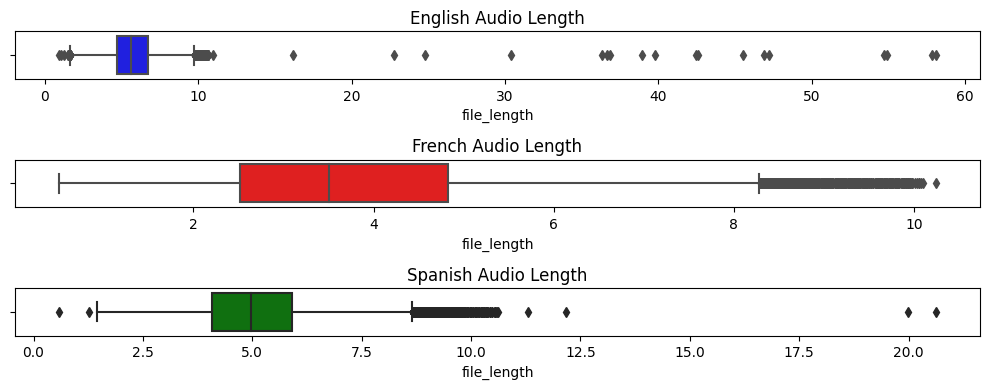

In [ ]:
#creating a box plot for audio length belonging to each class
plt.figure(figsize=(10, 4))
plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
sns.boxplot(x=df_en['file_length'].dropna(), color='blue')
plt.title('English Audio Length')  # Optional title for each subplot

# Plot for French
plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
sns.boxplot(x=df_fr['file_length'].dropna(), color='red')
plt.title('French Audio Length')

# Plot for Spanish
plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
sns.boxplot(x=df_sp['file_length'].dropna(), color='green')
plt.title('Spanish Audio Length')

# Display the plot
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

Most of out files are between 3 to 6 seconds in length.

Number of English files outside IQR: 558
Number of French files outside IQR: 768
Number of Spanish files outside IQR: 418


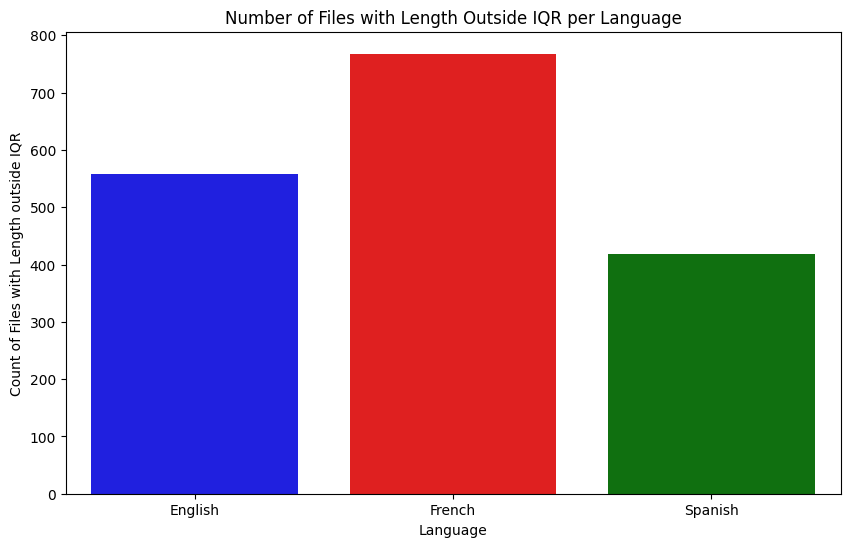

In [ ]:
def count_outside_iqr(df, column):
    """Function to count values outside the IQR in a DataFrame."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

# Count values outside IQR for each class
count_en_outside_iqr = count_outside_iqr(df_en, 'file_length')
count_fr_outside_iqr = count_outside_iqr(df_fr, 'file_length')
count_sp_outside_iqr = count_outside_iqr(df_sp, 'file_length')

# Print the results
print("Number of English files outside IQR:", count_en_outside_iqr)
print("Number of French files outside IQR:", count_fr_outside_iqr)
print("Number of Spanish files outside IQR:", count_sp_outside_iqr)

# Prepare data for visualization
data = {
    'Language': ['English', 'French', 'Spanish'],
    'Count_Above_Avg': [count_en_outside_iqr, count_fr_outside_iqr, count_sp_outside_iqr]
}
df_visual = pd.DataFrame(data)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Language', y='Count_Above_Avg', data=df_visual, palette=['blue', 'red', 'green'])
plt.title('Number of Files with Length Outside IQR per Language')
plt.xlabel('Language')
plt.ylabel('Count of Files with Length outside IQR')
plt.show()

We do have some files with recorded length outisde of IQR for their class, however based on the amount of data this number is very small. And I am interested in finding out how these varing length will impact the model, so I am just going to keep  a note if this and will come back to this if the model doesn't perform as expected or

Checking for class imbalance

<Axes: xlabel='label', ylabel='count'>

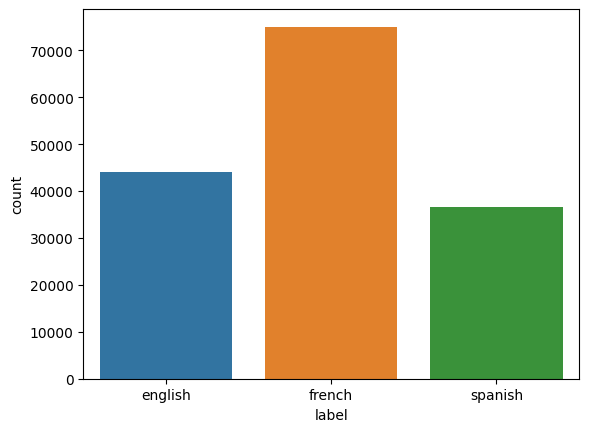

In [ ]:
#visualize classn imabalance
sns.countplot(x='label', data=df)

We can see we have a class imbalance, the number of french records are significantly greater than english and spanish, however the total recorded time is less .We will handle this before trainng.

## Feature generation - MFCC
### Reasons for Extracting MFCC
1. MFCCs are capable of capturing phonetically relevant features

2. MFCCs are resilient to Noise

3. MFCC's will also act as dimension reductionality expressing all audio files of different sizes with a fixed number of coefficinets


We will be extracting 40 components, no particular reason this number, just a random value to start our analysis, till the time all values are different for, the 3 languages it would be fine. If after a number of mfcc the difference becomes too small ,in that case we would have to reduce the number or else we would end up overfitting

In [ ]:
import librosa
import os
from tqdm import tqdm

In [ ]:


def extract_features(file_path):
    # Load the audio file
    audio, sample_rate = librosa.load(file_path)
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # Average MFCCs over time frames
    mfccs_processed = np.mean(mfccs.T, axis=0)

    return mfccs_processed

def load_data(data_path):
    features = []
    labels = []
    for folder in os.listdir(data_path):
        if os.path.isdir(os.path.join(data_path, folder)):
            for subfolder in tqdm(os.listdir(os.path.join(data_path, folder))):
                subfolder_path = os.path.join(data_path, folder, subfolder)
                if os.path.isdir(subfolder_path):
                    for file in os.listdir(subfolder_path):
                        if file.endswith('.mp3'):  # Assuming files are in MP3 format
                            file_path = os.path.join(subfolder_path, file)
                            data = extract_features(file_path)
                            features.append(data)
                            labels.append(folder)
    return features, labels

# Load the dataset
data_path = r'content/drive/MyDrive/data255'  # Change this to your dataset's path
features, labels = load_data(data_path)

# Convert to DataFrame
df = pd.DataFrame(features)
df['label'] = labels

print('Data loaded and split into training and testing sets.')
df.to_pickle('/content/drive/MyDrive/all_data.pkl')

'[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.4010951e-06\n  3.1398493e-05  2.6913716e-05]'

We can now check if the avg MFCC values of each language are different

In [ ]:
mfcc = pd.read_pickle('/content/drive/MyDrive/all_data.pkl')


In [ ]:
#find all the avg values of each MFCCs for each language
mfcc_group = mfcc.groupby('label').mean()

In [ ]:
mfcc_group.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
label,,,,,,,,,,,,,,,,,,,,,
english,-407.508698,87.702446,-0.111183,26.513285,-0.656181,-1.030688,-11.684328,-4.377366,-9.312958,-6.162546,...,-0.644699,-0.526957,-0.060771,-0.321868,0.303046,0.379177,-0.050406,0.274640,-0.203698,0.479346
french,-404.543427,87.962029,8.596828,25.501354,3.848017,2.683720,-2.579969,-2.832724,-4.974399,-2.328996,...,-1.473693,-1.012837,-1.515264,-0.632180,-1.618991,-0.442537,-1.647676,-0.131214,-1.636203,0.097072
spanish,-380.070374,122.038559,9.968734,15.024281,14.704643,-4.183995,-7.866689,-6.051092,-10.521976,-7.619818,...,-1.174578,-0.628684,-0.912430,-0.347905,-1.392000,-0.692989,-1.323618,-1.077927,-1.785266,-1.154706


In [ ]:
mfcc_group.describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,-397.374176,99.234344,6.151460,22.346308,5.965493,-0.843654,-7.376995,-4.420393,-8.269777,-5.370453,...,-1.097657,-0.722826,-0.829488,-0.433984,-0.902648,-0.252116,-1.007233,-0.311500,-1.208389,-0.192762
std,15.058689,19.749456,5.466813,6.361215,7.896297,3.437676,4.571891,1.609616,2.917203,2.732903,...,0.419816,0.256256,0.730785,0.172136,1.050312,0.560875,0.844330,0.694072,0.873274,0.854713
min,-407.508698,87.702446,-0.111183,15.024281,-0.656181,-4.183995,-11.684328,-6.051092,-10.521976,-7.619818,...,-1.473693,-1.012837,-1.515264,-0.632180,-1.618991,-0.692989,-1.647676,-1.077927,-1.785266,-1.154706
25%,-406.026062,87.832237,4.242823,20.262817,1.595918,-2.607342,-9.775508,-5.214229,-9.917467,-6.891182,...,-1.324135,-0.820761,-1.213847,-0.490043,-1.505495,-0.567763,-1.485647,-0.604571,-1.710734,-0.528817
50%,-404.543427,87.962029,8.596828,25.501354,3.848017,-1.030688,-7.866689,-4.377366,-9.312958,-6.162546,...,-1.174578,-0.628684,-0.912430,-0.347905,-1.392000,-0.442537,-1.323618,-0.131214,-1.636203,0.097072
75%,-392.306900,105.000294,9.282781,26.007319,9.276330,0.826516,-5.223329,-3.605045,-7.143678,-4.245771,...,-0.909638,-0.577821,-0.486601,-0.334886,-0.544477,-0.031680,-0.687012,0.071713,-0.919950,0.288209
max,-380.070374,122.038559,9.968734,26.513285,14.704643,2.683720,-2.579969,-2.832724,-4.974399,-2.328996,...,-0.644699,-0.526957,-0.060771,-0.321868,0.303046,0.379177,-0.050406,0.274640,-0.203698,0.479346


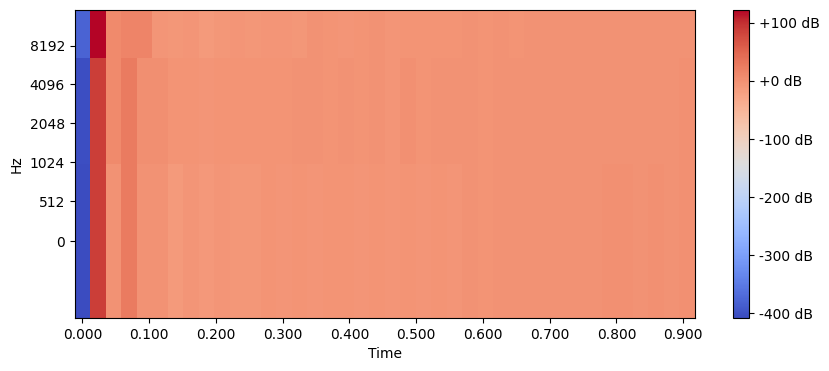

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_group.to_numpy(), x_axis='time', y_axis='mel', sr=22050)
plt.colorbar(format='%+2.0f dB')

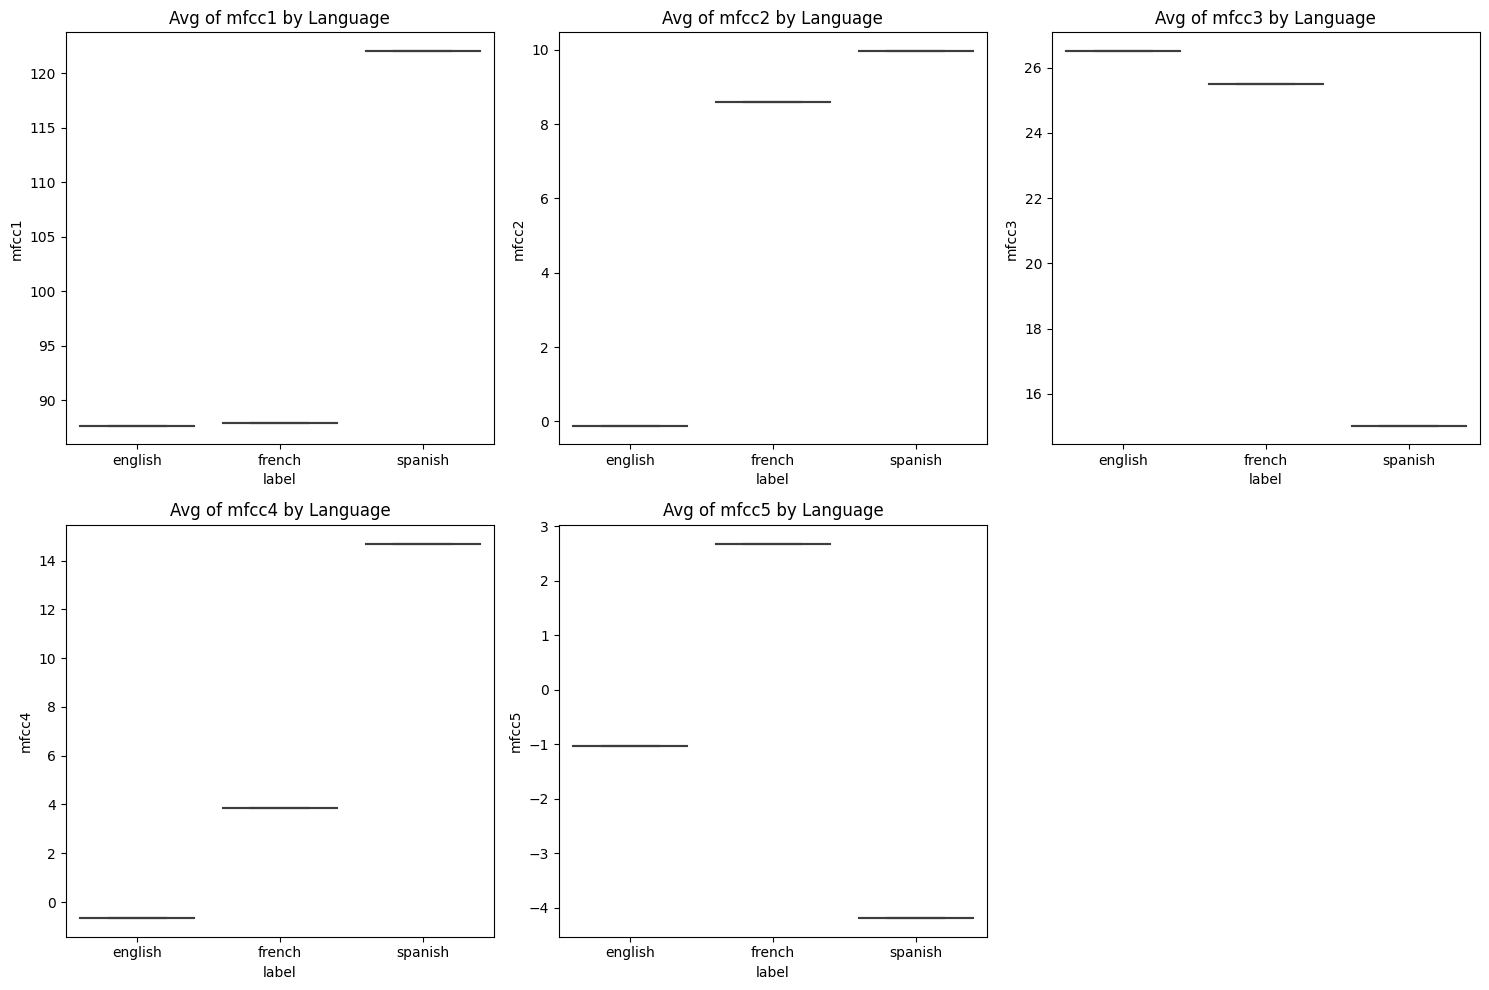

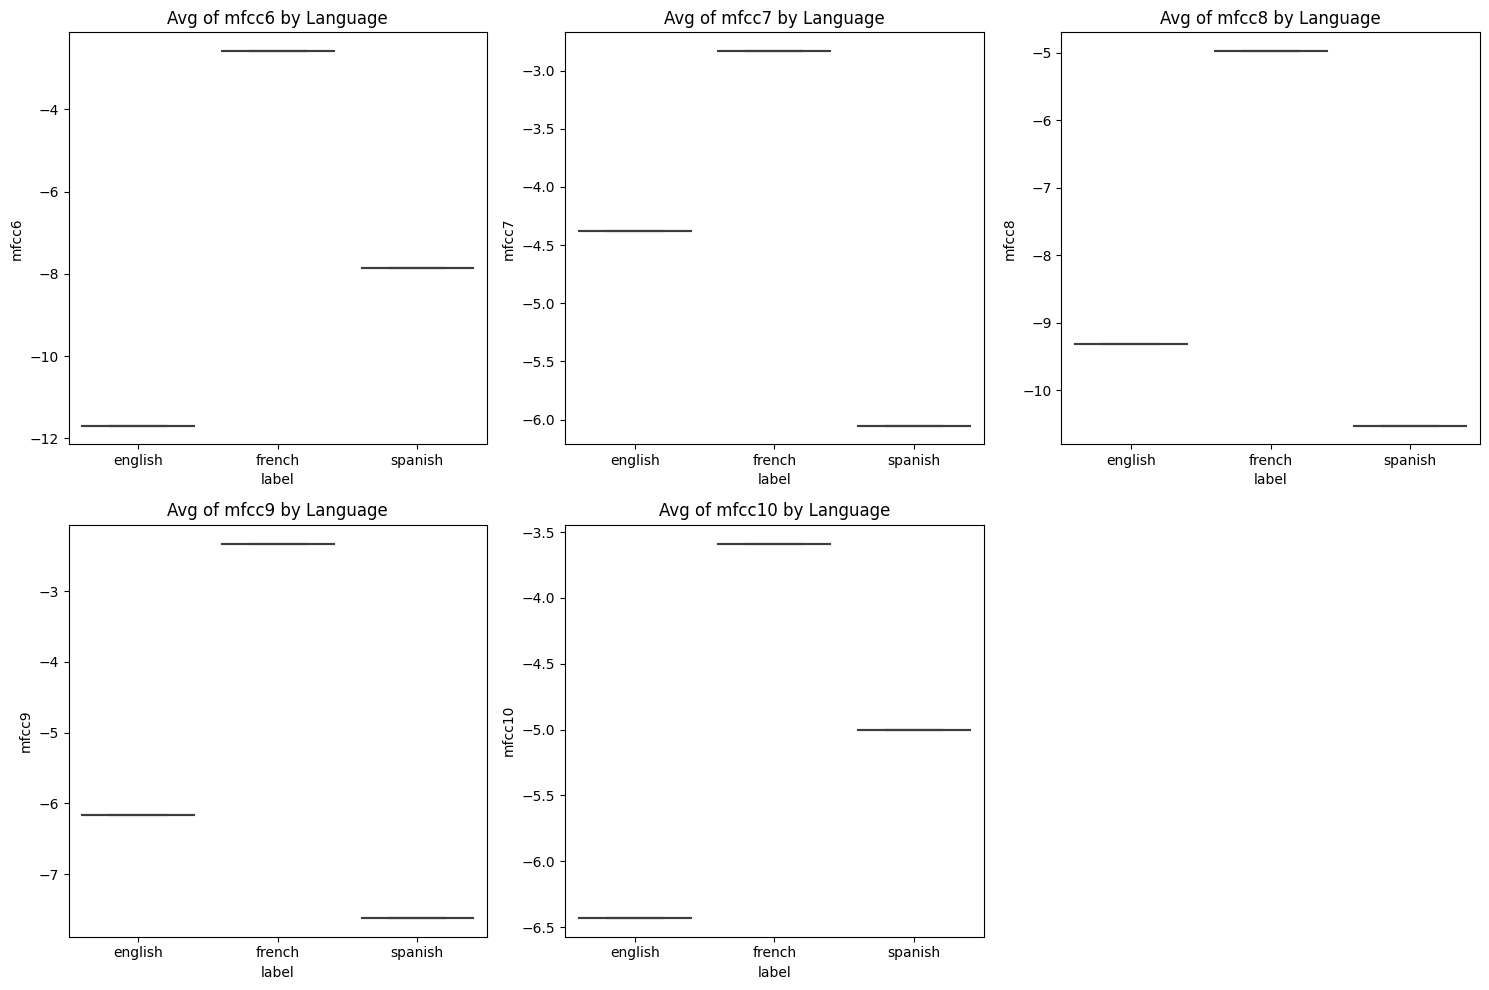

In [ ]:
#Visusalizing the MFCC values for different labels
# Function to create boxplots for a subset of MFCC features
def plot_mfcc_boxplots(df, start, end):
    features_to_plot = df.columns[start:end]
    n_features = len(features_to_plot)

    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features_to_plot, 1):
        plt.subplot(2, (n_features + 1) // 2, i)  # Adjust subplot layout
        sns.boxplot(x=df.index, y=feature, data=df)
        plt.title(f'Avg of {feature} by Language')

    plt.tight_layout()
    plt.show()

# Plotting the first two sets of MFCC features (mfcc0 to mfcc9)
plot_mfcc_boxplots(mfcc_group, 1, 6)  # mfcc0 to mfcc4
plot_mfcc_boxplots(mfcc_group, 6, 11)  # mfcc5 to mfcc9

From the above visualization we can clearly see that the avg MFCC values for each languages are different

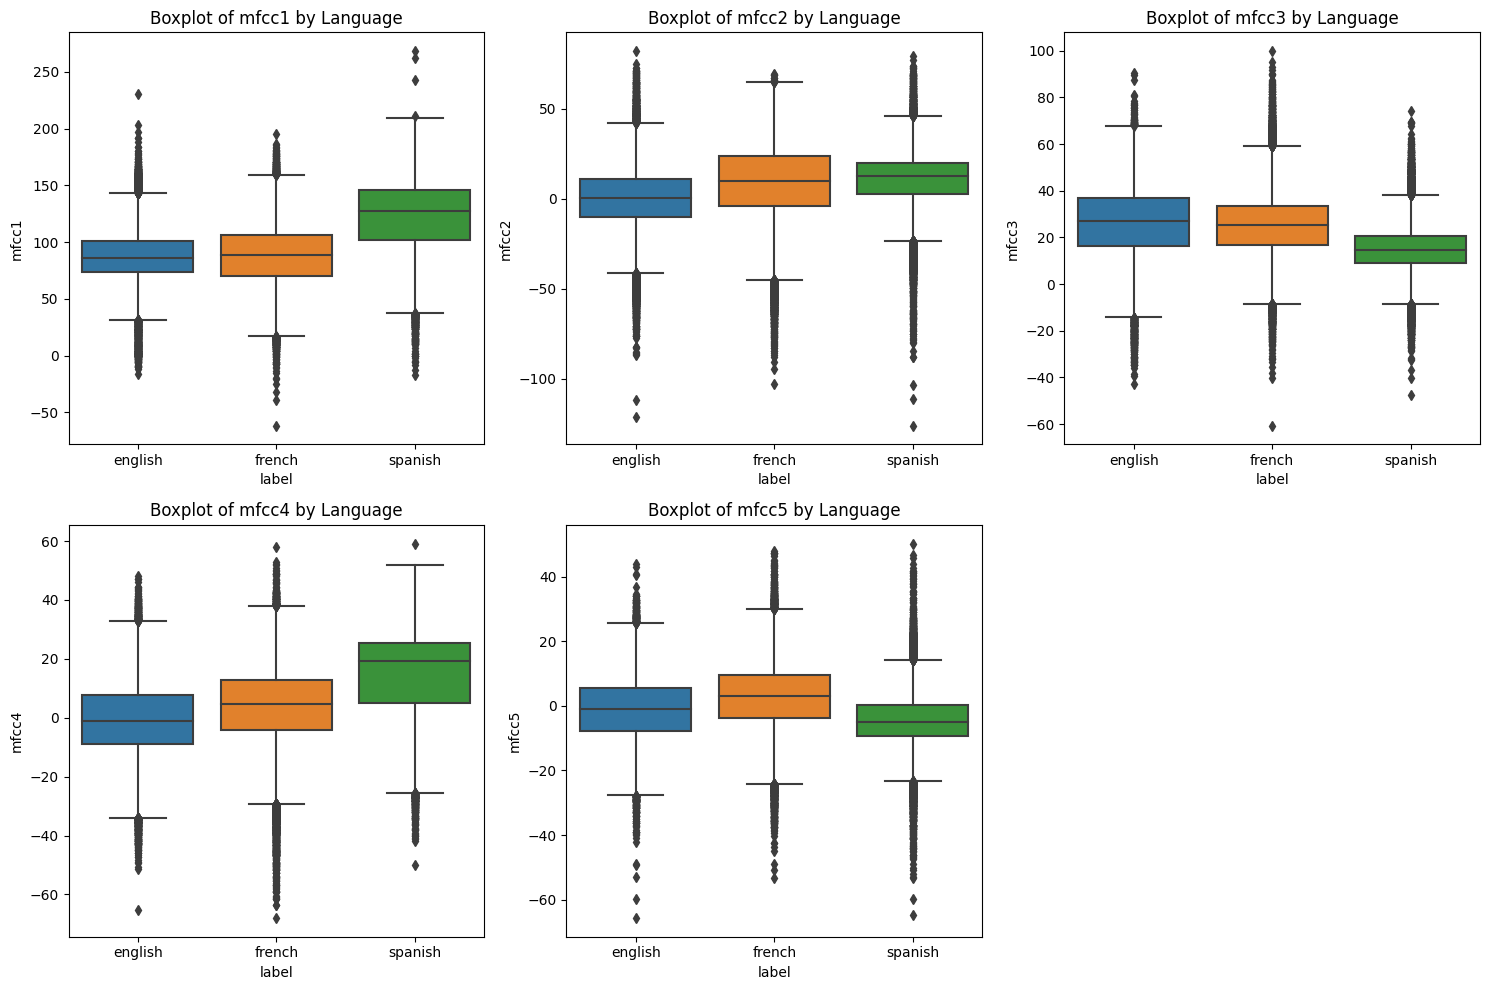

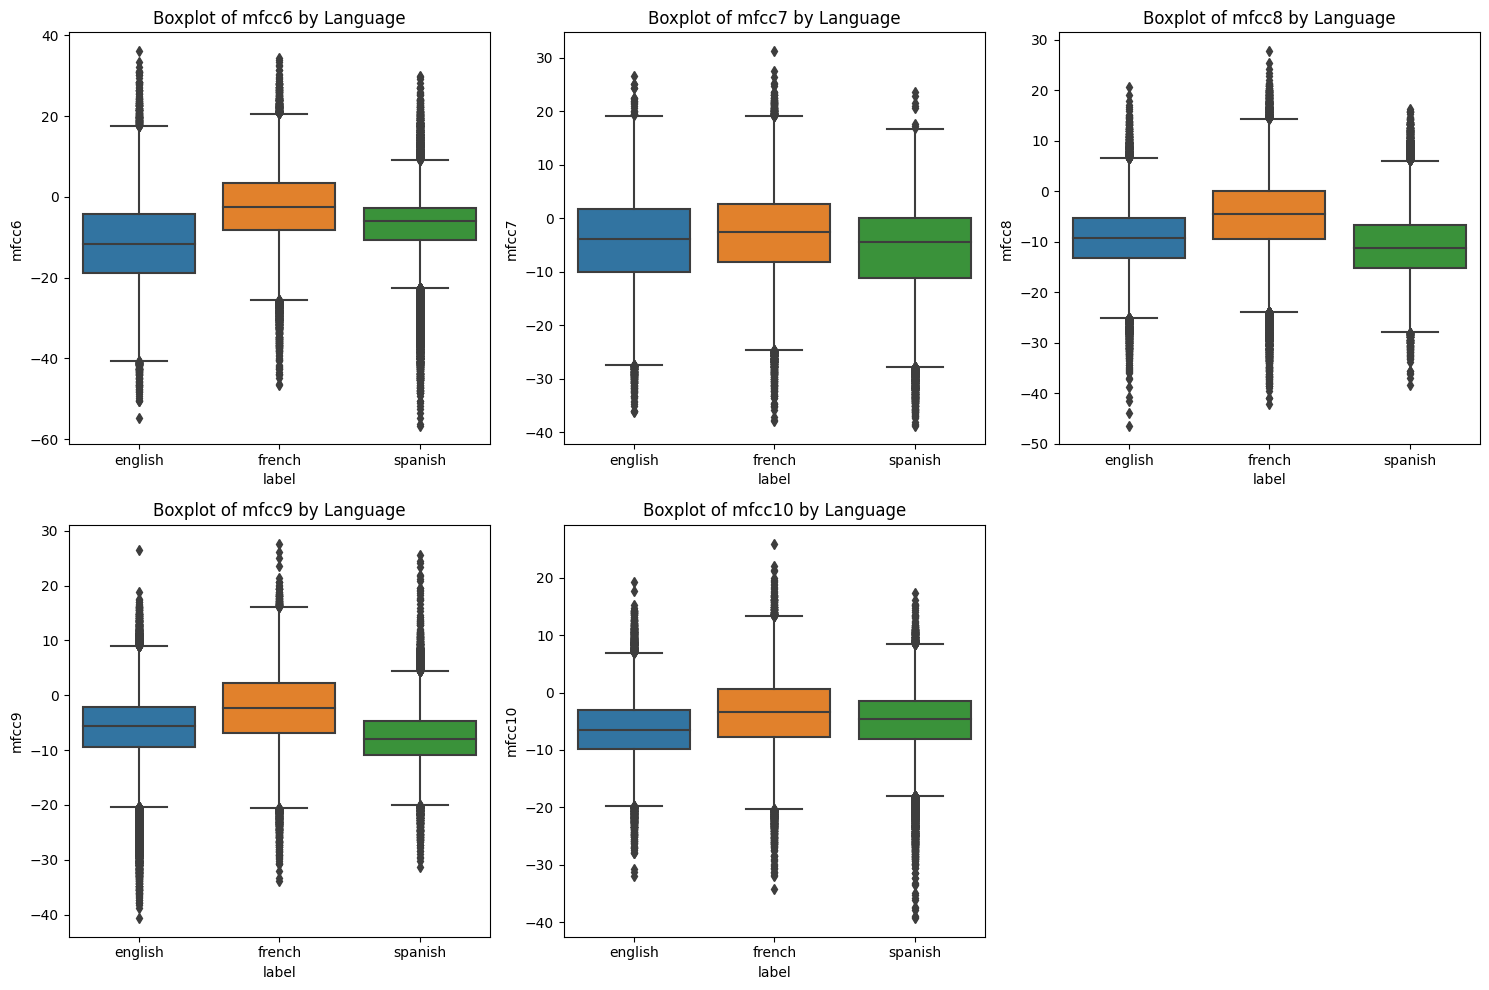

In [ ]:
#Visusalizing the MFCC values for different labels
# Function to create boxplots for a subset of MFCC features
def plot_mfcc_boxplots(df, start, end):
    features_to_plot = df.columns[start:end]
    n_features = len(features_to_plot)

    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features_to_plot, 1):
        plt.subplot(2, (n_features + 1) // 2, i)  # Adjust subplot layout
        sns.boxplot(x='label', y=feature, data=df)
        plt.title(f'Boxplot of {feature} by Language')

    plt.tight_layout()
    plt.show()

# Plotting the first two sets of MFCC features (mfcc0 to mfcc9)
plot_mfcc_boxplots(mfcc, 1, 6)  # mfcc0 to mfcc4
plot_mfcc_boxplots(mfcc, 6, 11)  # mfcc5 to mfcc9

When visualizing all MFFCs values for a particular coefficent, we can see that there exists a clear difference between the values, for all 3 labels. The data contrast is good and can be used for training the model